In [238]:
import pandas as pd
import sqlite3

# 1. Connect to the database
conn = sqlite3.connect("pilot 4 annotations/annotations_pilot4.db")

db_annotations = pd.read_sql_query("SELECT * FROM annotations;", conn)
db_demographics = pd.read_sql_query("SELECT * FROM demographics;", conn)
stimuli = pd.read_sql_query("SELECT * FROM stimuli;", conn)


# 4. Close the connection
conn.close()

column_names = ['prolific_id', 'session_id', 'gender', 'gender_other', 'age',
       'nationality', 'ethnicity', 'ethn_free', 'language', 'religion',
       'education', 'big_1', 'big_2', 'big_3', 'big_4', 'big_5', 'big_6',
       'big_7', 'big_8', 'big_9', 'big_10']

annotation_columns = [ 'prolific_id', 'session_id', 'candidate_id',
       'knowledge', 'power', 'status', 'trust', 'support', 'similarity',
       'identity', 'fun', 'conflict', 'other', 'other_sp', 'none', 'romance']

sh_demographics = pd.read_csv('pilot 3 annotations/Demographics - Sheet1.tsv', header=None, names=column_names, sep = '\t')
sh_annotations = pd.read_csv('pilot 3 annotations/Annotations - Sheet1.tsv', sep = '\t')
sh_annotations.columns = annotation_columns
sh_annotations = sh_annotations.merge(stimuli, how='left', left_on='candidate_id', right_on='id')

cols = ['knowledge', 'power', 'status', 'trust', 'support', 'similarity', 
        'identity', 'fun', 'conflict', 'other', 'none', 'romance']

def to_bool(val):
    if str(val).lower() in ['0', 'false']:
        return False
    elif str(val).lower() in ['1', 'true']:
        return True
    else:
        return False  # or np.nan if you want to mark invalid values

db_annotations[cols] = db_annotations[cols].applymap(to_bool)
db_annotations = db_annotations.merge(stimuli, how = 'left', left_on = 'candidate_id', right_on = 'new_id')


demographics = pd.concat([sh_demographics, db_demographics])
annotations = pd.concat([sh_annotations, db_annotations])

annotations = annotations[~annotations['prolific_id'].isin(['test', 'test1', 'TEST', 'amanda', '12345', 'pat', 'patata', '662f76e4289b048f450f6fff'])]
demographics = demographics[~demographics['prolific_id'].isin(['test', 'test1', 'TEST', 'amanda', '12345', 'pat', 'patata', '662f76e4289b048f450f6fff'])].drop_duplicates()




/var/folders/j5/d7yf57zj04d8wxhwp77l81dr0000gn/T/ipykernel_22772/434276702.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  db_annotations[cols] = db_annotations[cols].applymap(to_bool)


# Demographics Description

In [239]:
len(demographics.prolific_id.unique())

75

In [240]:
for col in ['gender', 'age',
       'nationality', 'ethnicity', 'language', 'religion',
       'education']:
    print(f"\n{col.upper()}")
    print(demographics[col].value_counts(dropna=False))


GENDER
gender
Male      42
Female    35
Name: count, dtype: int64

AGE
age
35-44    22
45-54    19
25-34    14
55-60     9
60+       9
18-24     4
Name: count, dtype: int64

NATIONALITY
nationality
United Kingdom    69
United States      5
Ireland            3
Name: count, dtype: int64

ETHNICITY
ethnicity
White / Caucasian            68
Asian / Pacific Islander      5
Black or African American     2
NaN                           1
Hispanic                      1
Name: count, dtype: int64

LANGUAGE
language
English    73
            3
NaN         1
Name: count, dtype: int64

RELIGION
religion
NaN          29
Christian    23
None         19
Muslim        5
Buddhist      1
Name: count, dtype: int64

EDUCATION
education
Undergraduate degree    28
High school or below    27
Graduate degree         15
Doctorate or above       6
Prefer not to say        1
Name: count, dtype: int64


In [241]:
annotations_per_person = (
    annotations['prolific_id']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'prolific_id', 'prolific_id': 'n_annotations'})
)
annotations_per_person.describe()


,count
count,67.000000
mean,34.492537
std,20.050975
min,1.000000
25%,14.000000
50%,50.000000
75%,50.000000
max,61.000000


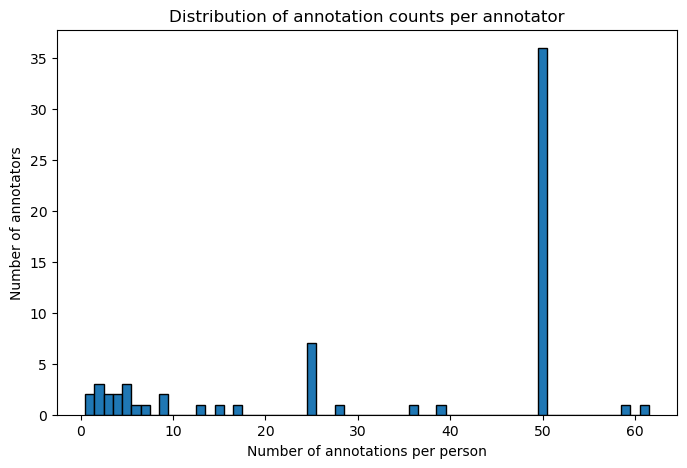

In [242]:
import matplotlib.pyplot as plt

counts = annotations['prolific_id'].value_counts()
plt.figure(figsize=(8,5))
plt.hist(counts, bins=range(1, counts.max()+2), edgecolor='black', align='left')
plt.xlabel('Number of annotations per person')
plt.ylabel('Number of annotators')
plt.title('Distribution of annotation counts per annotator')
plt.show()

## Big 5

In [243]:

demographics.columns = ['prolific_id', 'session_id', 'gender', 'gender_other', 'age',
       'nationality', 'ethnicity', 'ethn_free', 'language', 'religion',
       'education', 'reserved', 'trusting', 'lazy', 'relaxed', 'not_artistic', 'outgoing', 'hates_others', 'detailed', 'nervous', 'imaginative']

big5 = ['reserved', 'trusting', 'lazy', 'relaxed', 'not_artistic', 'outgoing', 'hates_others', 'detailed', 'nervous', 'imaginative']
df = demographics

response_map = {
    "Strongly disagree": 1,
    "Disagree": 2,
    "Neutral": 3,
    "Agree": 4,
    "Strongly agree": 5
}

for col in big5:
    df[col] = df[col].map(response_map)


reverse_scored = ['reserved', 'hates_others', 'lazy', 'relaxed', 'not_artistic']

def reverse_score(row, column):
    return 6 - row[column]  

for column in reverse_scored:
    df[column] = df.apply(lambda row: reverse_score(row, column), axis=1)

df['Openness'] = df['imaginative'] + df['not_artistic']
df['Conscientiousness'] = df['lazy'] + df['detailed']
df['Extraversion'] = df['reserved'] + df['outgoing']
df['Agreeableness'] = df['trusting'] + df['hates_others']
df['Neuroticism'] = df['relaxed'] + df['nervous']

personality_columns = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']

df[['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']].describe()

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
count,77.000000,77.000000,77.000000,76.000000,77.000000
mean,7.298701,7.727273,5.311688,6.907895,5.740260
std,2.006994,1.944198,2.255168,1.841576,2.284977
min,2.000000,3.000000,2.000000,2.000000,2.000000
25%,6.000000,6.000000,4.000000,6.000000,4.000000
50%,8.000000,8.000000,5.000000,7.000000,5.000000
75%,9.000000,9.000000,7.000000,8.250000,8.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000


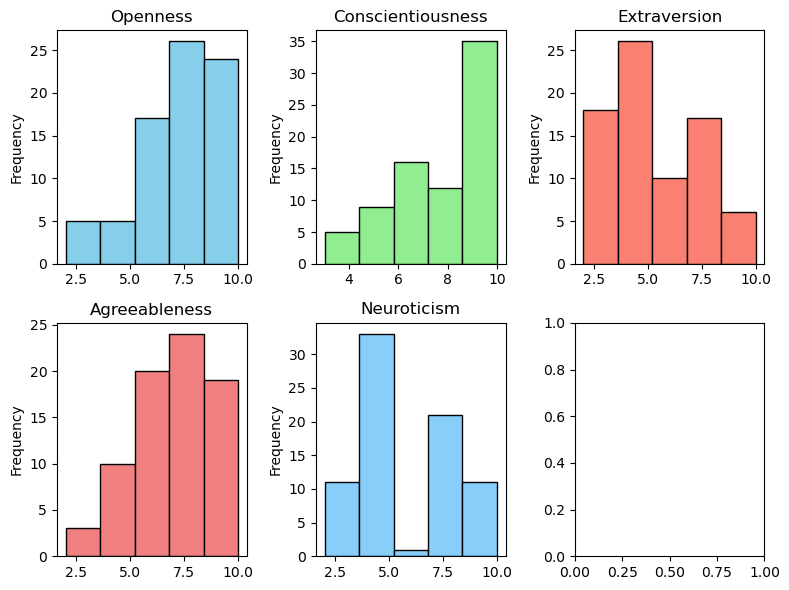

In [244]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

df['Openness'].plot(kind='hist', ax=axes[0, 0], bins=5, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Openness')

df['Conscientiousness'].plot(kind='hist', ax=axes[0, 1], bins=5, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Conscientiousness')

df['Extraversion'].plot(kind='hist', ax=axes[0, 2], bins=5, color='salmon', edgecolor='black')
axes[0, 2].set_title('Extraversion')

df['Agreeableness'].plot(kind='hist', ax=axes[1, 0], bins=5, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Agreeableness')

df['Neuroticism'].plot(kind='hist', ax=axes[1, 1], bins=5, color='lightskyblue', edgecolor='black')
axes[1, 1].set_title('Neuroticism')

plt.tight_layout()
plt.show()

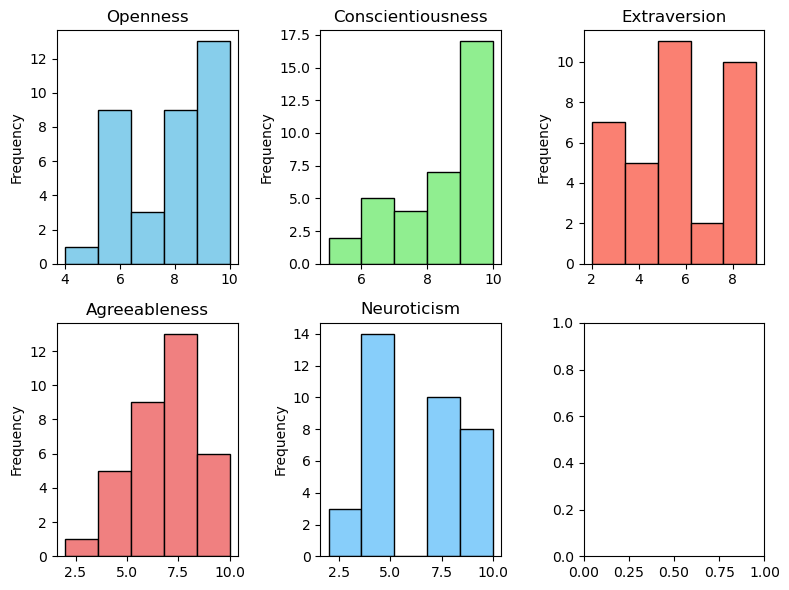

In [263]:
women = df[df['gender']=='Female']
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

women['Openness'].plot(kind='hist', ax=axes[0, 0], bins=5, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Openness')

women['Conscientiousness'].plot(kind='hist', ax=axes[0, 1], bins=5, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Conscientiousness')

women['Extraversion'].plot(kind='hist', ax=axes[0, 2], bins=5, color='salmon', edgecolor='black')
axes[0, 2].set_title('Extraversion')

women['Agreeableness'].plot(kind='hist', ax=axes[1, 0], bins=5, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Agreeableness')

women['Neuroticism'].plot(kind='hist', ax=axes[1, 1], bins=5, color='lightskyblue', edgecolor='black')
axes[1, 1].set_title('Neuroticism')

plt.tight_layout()
plt.show()

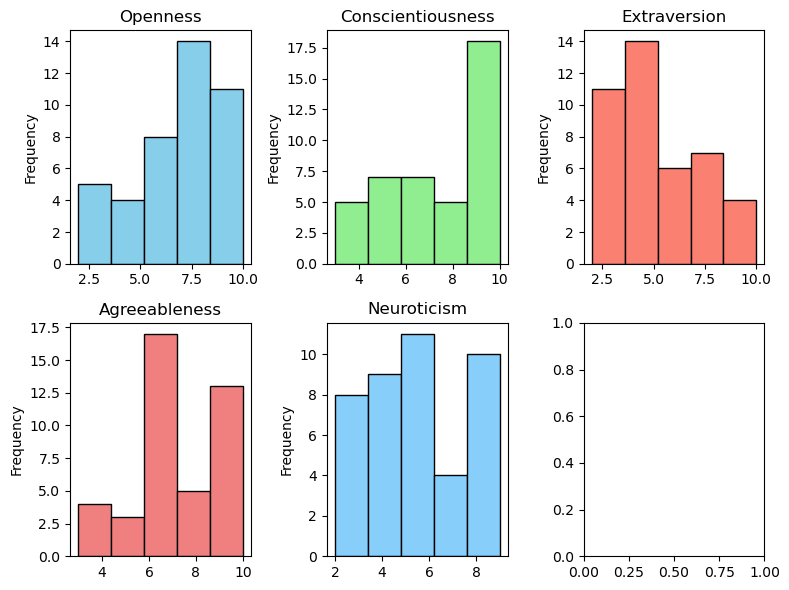

In [246]:
men = df[df['gender']=='Male']
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

men['Openness'].plot(kind='hist', ax=axes[0, 0], bins=5, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Openness')

men['Conscientiousness'].plot(kind='hist', ax=axes[0, 1], bins=5, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Conscientiousness')

men['Extraversion'].plot(kind='hist', ax=axes[0, 2], bins=5, color='salmon', edgecolor='black')
axes[0, 2].set_title('Extraversion')

men['Agreeableness'].plot(kind='hist', ax=axes[1, 0], bins=5, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Agreeableness')

men['Neuroticism'].plot(kind='hist', ax=axes[1, 1], bins=5, color='lightskyblue', edgecolor='black')
axes[1, 1].set_title('Neuroticism')

plt.tight_layout()
plt.show()

## Annotation Analysis

In [247]:
annotations

,prolific_id,session_id,candidate_id,knowledge,power,status,trust,support,similarity,identity,...,author,subreddit,id,text,dataset,video_id,reply_date,category,valid_annotations,annotation_id
25,5f649a5cd14d460266092062,68b6fda37116ad723ad7aec7,1.80035E+16,False,False,False,True,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,5f649a5cd14d460266092062,68b6fda37116ad723ad7aec7,id_1846,False,False,False,False,False,False,False,...,None,None,id_1846,"Nice one Marcus, keep it up. YES, alcohol has ...",youtube,Fg7U-BhiZGE,2025-05-27T18:51:23Z,People & Blogs,13.0,NaN
27,5f649a5cd14d460266092062,68b6fda37116ad723ad7aec7,hlwbnv0,False,False,False,False,False,False,True,...,Mr_Flint_Stone,isopodexchange,hlwbnv0,It looks like Battlenet is having a Black Frid...,reddit,None,None,None,9.0,NaN
28,5b5f23420085cb0001872849,68b6fdafd16b816ce170e76c,id_1269,False,False,False,False,True,False,False,...,None,None,id_1269,Happy new year to all.\n\nI'm guessing it's so...,youtube,JgtJ-sFzWww,2025-01-01T15:36:14Z,Entertainment,12.0,NaN
29,5f649a5cd14d460266092062,68b6fda37116ad723ad7aec7,1.78687E+16,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,660453c9877e571d12b555f7,68f7706cddc3902ad5979a81,756f3bc5-5b7f-4ecd-b307-e57448578f52,True,False,False,False,False,False,False,...,None,None,id_1666,DDLC is much more accessible to a general audi...,youtube,krq6-1ht_kk,2018-04-05T01:39:56Z,Gaming,4.0,1506.0
1506,660453c9877e571d12b555f7,68f7706cddc3902ad5979a81,f757ebc8-6c83-44f1-b35f-e1d327960fbf,False,False,True,False,False,False,False,...,The-Ravioli-Mage,TwoBestFriendsPlay,geb2u3g,I wonder if it’s going to be difficult for him...,reddit,None,None,None,9.0,1507.0
1507,660453c9877e571d12b555f7,68f7706cddc3902ad5979a81,4941e9cf-641c-476a-a58f-f2e85a298107,False,False,False,False,True,False,False,...,None,None,id_2073,Hello My friend thank you for watching.No noth...,youtube,O_4uU6-6jC8,2022-10-26T05:56:02Z,Gaming,4.0,1508.0
1508,660453c9877e571d12b555f7,68f7706cddc3902ad5979a81,940b5f62-c788-4273-a78d-cb11cc6aaa4f,False,False,False,True,False,False,False,...,None,None,id_448,Emma Taylor haha I’m barely on here but I’m tr...,youtube,2q82-0varGc,2020-04-28T12:20:31Z,People & Blogs,6.0,1509.0


In [248]:
# Sum across all examples for each social dimension
overall_counts = annotations[cols].sum()

# Or as proportions (fraction of examples with that dimension)
overall_props = annotations[cols].mean()

print("Counts:\n", overall_counts)
print("\nProportions:\n", overall_props.round(2))

Counts:
 knowledge     846
power         139
status        303
trust         189
support       660
similarity    570
identity      378
fun           319
conflict      355
other          12
none          165
romance        57
dtype: int64

Proportions:
 knowledge     0.37
power         0.06
status        0.13
trust         0.08
support       0.29
similarity    0.25
identity      0.16
fun           0.14
conflict      0.15
other         0.01
none          0.07
romance       0.02
dtype: float64


In [249]:
platform_props = annotations.groupby('dataset')[cols].mean().round(2)
print(platform_props)

           knowledge  power  status  trust  support  similarity  identity  \
dataset                                                                     
instagram       0.28   0.03    0.21   0.17     0.43        0.40      0.24   
reddit          0.40   0.08    0.09   0.05     0.22        0.20      0.14   
youtube         0.39   0.07    0.12   0.06     0.26        0.19      0.14   

            fun  conflict  other  none  romance  
dataset                                          
instagram  0.19      0.05   0.00  0.01     0.04  
reddit     0.11      0.19   0.00  0.09     0.02  
youtube    0.10      0.18   0.01  0.09     0.01  


In [250]:
annotations['dataset'].value_counts()

dataset
youtube      796
reddit       756
instagram    476
Name: count, dtype: int64

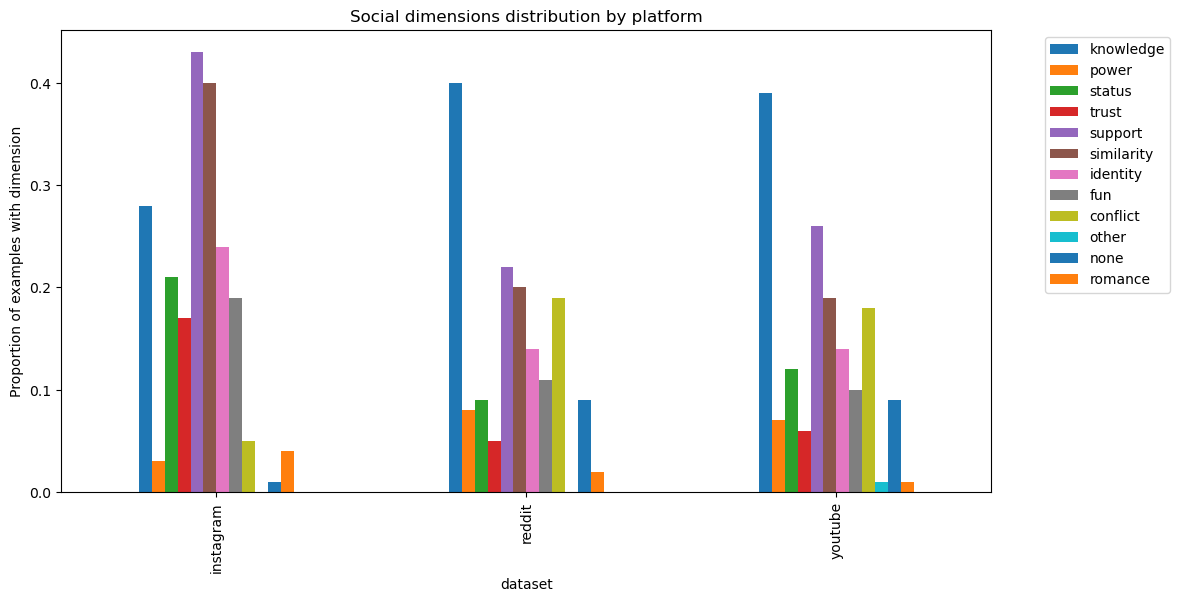

In [251]:
platform_props.plot(kind='bar', figsize=(12,6))
plt.ylabel('Proportion of examples with dimension')
plt.title('Social dimensions distribution by platform')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [252]:
annotations =annotations.merge(demographics, how='left', on=['prolific_id', 'session_id'])
dims = ['knowledge', 'power', 'status', 'trust', 'support', 
        'similarity', 'identity', 'fun', 'conflict', 'other', 'none', 'romance']

gender_props = annotations.groupby('gender')[dims].mean().round(2)
print(gender_props)

        knowledge  power  status  trust  support  similarity  identity   fun  \
gender                                                                         
Female       0.35   0.07    0.14   0.08     0.31        0.25      0.17  0.14   
Male         0.39   0.05    0.12   0.08     0.26        0.24      0.15  0.14   

        conflict  other  none  romance  
gender                                  
Female      0.15   0.01  0.08     0.02  
Male        0.16   0.00  0.07     0.03  


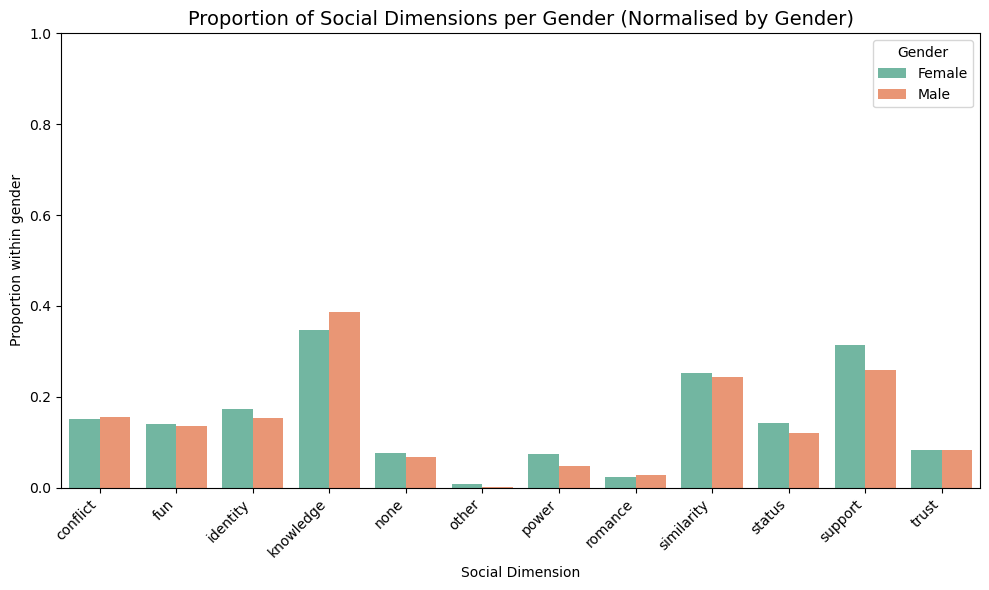

In [253]:
# --- Melt (wide → long) ---
long_df = annotations.melt(
    id_vars=['gender'],
    value_vars=dims,
    var_name='dimension',
    value_name='selected'
)

# --- Keep only rows where the dimension was selected (1) ---
long_df = long_df[long_df['selected'] == 1]

# --- Count annotations per gender × dimension ---
counts = long_df.groupby(['gender', 'dimension']).size().reset_index(name='count')

# --- Compute total number of annotations per gender ---
totals = annotations.groupby('gender').size().reset_index(name='total')

# --- Merge and normalize ---
merged = counts.merge(totals, on='gender')
merged['proportion'] = merged['count'] / merged['total']

# --- Sort for nicer plotting ---
merged = merged.sort_values(by=['dimension', 'gender'])

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=merged,
    x='dimension',
    y='proportion',
    hue='gender',
    palette='Set2'
)
plt.title('Proportion of Social Dimensions per Gender (Normalised by Gender)', fontsize=14)
plt.ylabel('Proportion within gender')
plt.xlabel('Social Dimension')
plt.ylim(0, 1)
plt.legend(title='Gender')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/var/folders/j5/d7yf57zj04d8wxhwp77l81dr0000gn/T/ipykernel_22772/2588333983.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/j5/d7yf57zj04d8wxhwp77l81dr0000gn/T/ipykernel_22772/2588333983.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


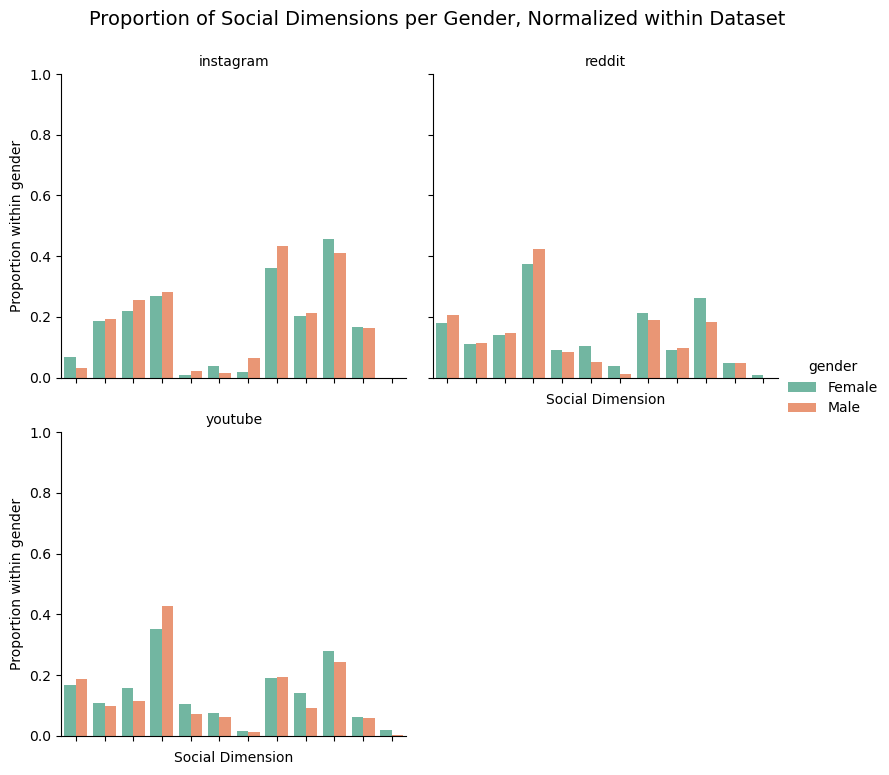

In [254]:
# --- Melt (wide → long) ---
long_df = annotations.melt(
    id_vars=['gender', 'dataset'],
    value_vars=dims,
    var_name='dimension',
    value_name='selected'
)

# --- Keep only rows where the dimension was selected (1) ---
long_df = long_df[long_df['selected'] == 1]
# --- Count annotations per dataset × gender × dimension ---
counts = long_df.groupby(['dataset', 'gender', 'dimension']).size().reset_index(name='count')

# --- Compute total annotations per dataset × gender ---
totals = annotations.groupby(['dataset', 'gender']).size().reset_index(name='total')

# --- Merge and normalize ---
merged = counts.merge(totals, on=['dataset', 'gender'])
merged['proportion'] = merged['count'] / merged['total']

# --- Sort for clean plotting ---
merged = merged.sort_values(by=['dataset', 'dimension', 'gender'])

# --- Plot: one facet per dataset ---
g = sns.catplot(
    data=merged,
    x='dimension',
    y='proportion',
    hue='gender',
    col='dataset',
    kind='bar',
    col_wrap=2,           # adjust depending on number of datasets
    height=4,
    sharey=True,
    palette='Set2'
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('Social Dimension', 'Proportion within gender')
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 1)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Proportion of Social Dimensions per Gender, Normalized within Dataset', fontsize=14)
plt.show()


## Big 5

In [255]:
big_5 = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness',
       'Neuroticism']

corr = annotations[big_5 + dims].corr().loc[big_5, dims]
print(corr.round(2))

                   knowledge  power  status  trust  support  similarity  \
Openness               -0.05   0.05    0.05   0.04     0.04       -0.06   
Conscientiousness      -0.07   0.06   -0.00   0.04     0.02       -0.04   
Extraversion            0.03   0.02   -0.05   0.02     0.06        0.04   
Agreeableness          -0.06   0.06   -0.04   0.05     0.08       -0.06   
Neuroticism             0.04   0.03    0.05  -0.03    -0.01        0.03   

                   identity   fun  conflict  other  none  romance  
Openness              -0.07  0.01      0.04   0.09 -0.08    -0.03  
Conscientiousness     -0.04  0.03     -0.02   0.01  0.00     0.01  
Extraversion           0.08 -0.02      0.00   0.02 -0.02     0.04  
Agreeableness         -0.08  0.03      0.01   0.04 -0.01     0.01  
Neuroticism           -0.00 -0.01     -0.02   0.05  0.03    -0.04  


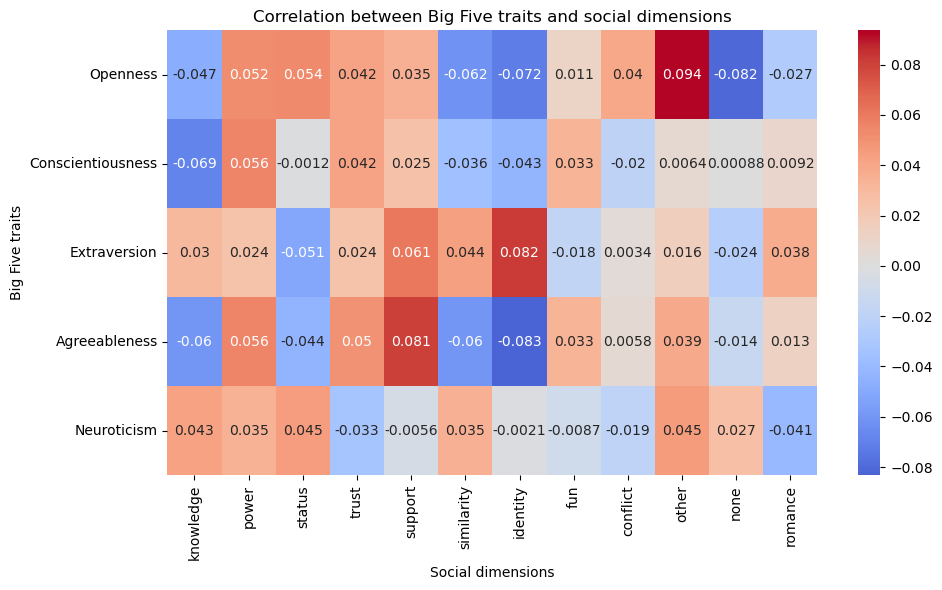

In [256]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Big Five traits and social dimensions')
plt.xlabel('Social dimensions')
plt.ylabel('Big Five traits')
plt.tight_layout()
plt.show()

In [257]:
# Aggregate by example_id, use max() to perform logical OR on booleans
annotations_agg = (
    annotations
    .groupby('candidate_id')
    .agg({**{dim: 'max' for dim in dims}, 'dataset': 'first'})
    .reset_index()
)

# Optional: inspect the result
print(annotations_agg.head())

                           candidate_id  knowledge  power  status  trust  \
0  0169c659-8d7a-4abe-9fbc-24ca13da3380       True  False    True   True   
1  016f23ac-544f-4ef6-a361-5ee4469595c0      False  False   False  False   
2  0215520b-8a20-4019-8afb-8f95b8c2020e       True  False    True   True   
3  02d0e0e4-a407-4f19-8233-f2f642015258       True  False    True  False   
4  040bb11a-1e9e-40f4-a88c-03571e7eaa57       True  False   False  False   

   support  similarity  identity    fun  conflict  other   none  romance  \
0     True        True      True  False      True  False  False    False   
1     True        True     False  False     False  False  False    False   
2     True        True      True   True     False  False  False    False   
3    False        True     False   True     False  False   True    False   
4     True        True      True   True      True  False  False    False   

     dataset  
0  instagram  
1    youtube  
2  instagram  
3     reddit  
4     reddi

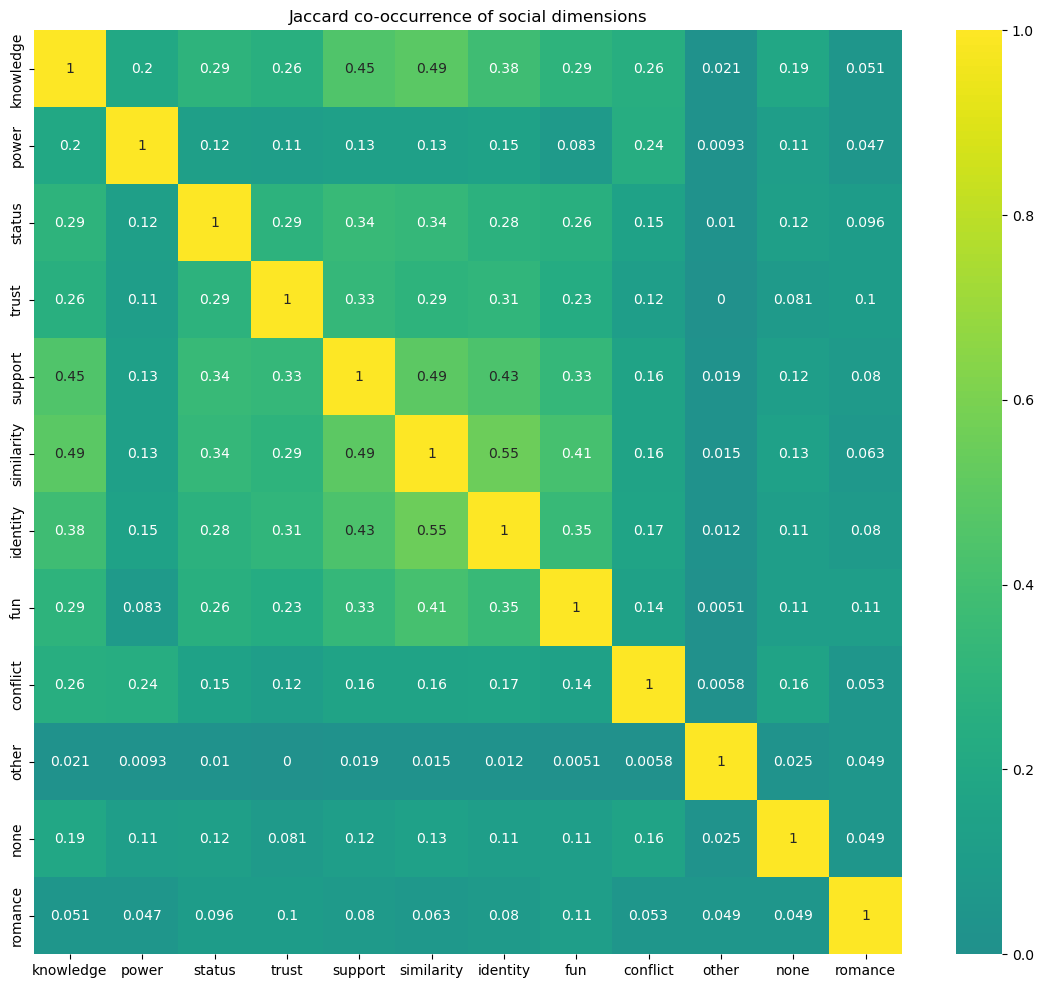

In [258]:
cooccurrence_jaccard = pd.DataFrame(index=dims, columns=dims)

for d1 in dims:
    for d2 in dims:
        cooccurrence_jaccard.loc[d1,d2] = (
            (annotations_agg[d1] & annotations_agg[d2]).sum() / (annotations_agg[d1] | annotations_agg[d2]).sum()
        )

cooccurrence_jaccard = cooccurrence_jaccard.astype(float)
plt.figure(figsize=(14,12))
sns.heatmap(cooccurrence_jaccard, annot=True, cmap='viridis', center=0)
plt.title('Jaccard co-occurrence of social dimensions')
plt.show()

            knowledge  power  status  trust  support  similarity  identity  \
knowledge       1.000  0.064   0.066  0.079    0.253       0.222     0.137   
power           0.388  1.000   0.129  0.079    0.216       0.072     0.079   
status          0.185  0.059   1.000  0.132    0.363       0.261     0.178   
trust           0.354  0.058   0.212  1.000    0.423       0.344     0.265   
support         0.324  0.045   0.167  0.121    1.000       0.285     0.215   
similarity      0.330  0.018   0.139  0.114    0.330       1.000     0.358   
identity        0.307  0.029   0.143  0.132    0.376       0.540     1.000   
fun             0.223  0.009   0.141  0.116    0.292       0.429     0.241   
conflict        0.192  0.118   0.039  0.020    0.045       0.045     0.068   
other           0.250  0.000   0.000  0.000    0.000       0.083     0.167   
none            0.000  0.000   0.000  0.000    0.000       0.000     0.000   
romance         0.123  0.035   0.175  0.088    0.193       0.246

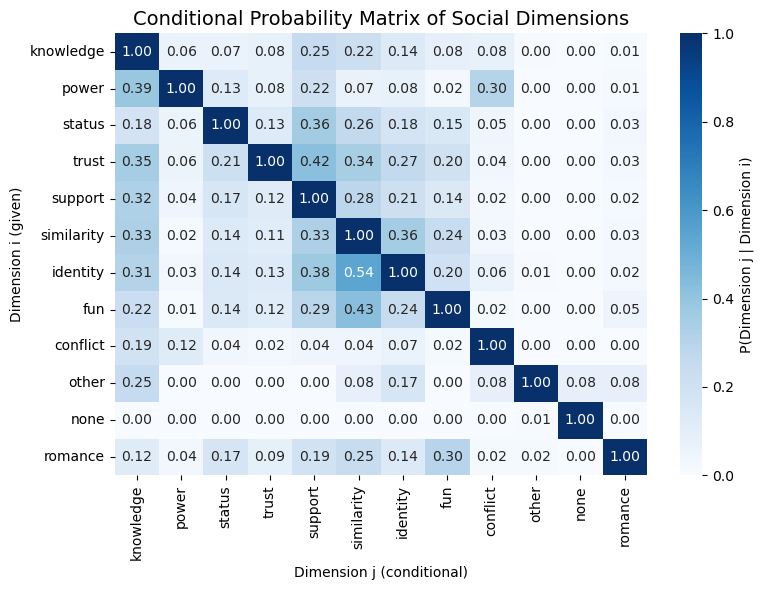

In [259]:

# --- Extract only the relevant columns ---
df_dims = annotations[dims].astype(int)

# --- Compute conditional probabilities ---
cond_probs = pd.DataFrame(index=dims, columns=dims, dtype=float)

for i in dims:
    for j in dims:
        # P(j | i) = P(i & j) / P(i)
        numerator = ((df_dims[i] == 1) & (df_dims[j] == 1)).sum()
        denominator = (df_dims[i] == 1).sum()
        cond_probs.loc[i, j] = numerator / denominator if denominator > 0 else np.nan

# --- Round for readability ---
cond_probs = cond_probs.round(3)

# --- Display the matrix ---
print(cond_probs)

# --- Plot as a heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(cond_probs, annot=True, cmap='Blues', fmt=".2f",
            cbar_kws={'label': 'P(Dimension j | Dimension i)'})
plt.title('Conditional Probability Matrix of Social Dimensions', fontsize=14)
plt.xlabel('Dimension j (conditional)')
plt.ylabel('Dimension i (given)')
plt.tight_layout()
plt.show()


In [260]:
annotations.to_csv('collected_data_oct_14.csv')

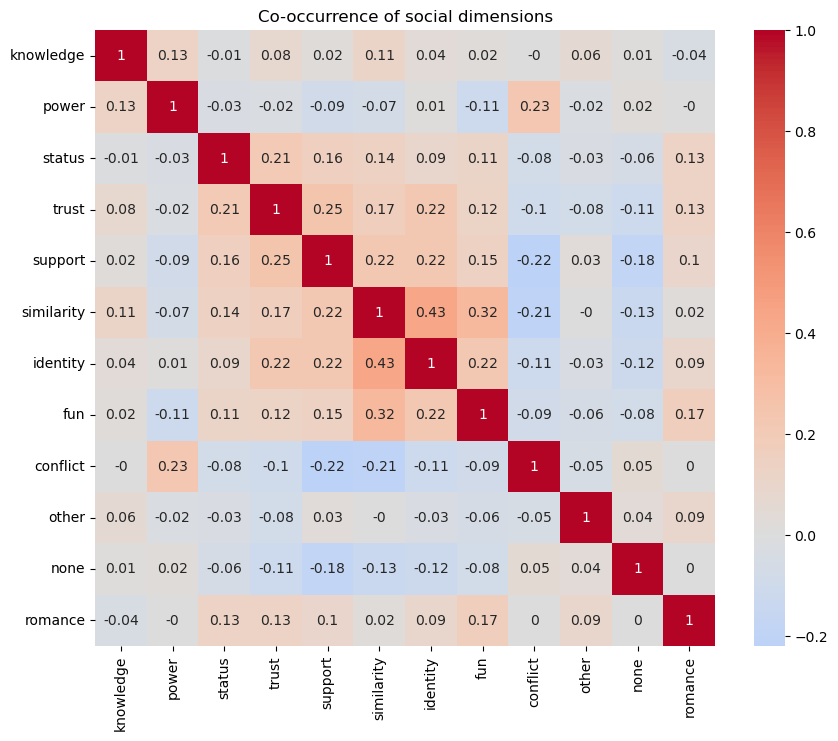

In [261]:
# Compute correlation matrix (Pearson works fine for booleans)
cooccurrence = annotations_agg[dims].corr()

# Optional: round for easier visualization
cooccurrence = cooccurrence.round(2)

plt.figure(figsize=(10,8))
sns.heatmap(cooccurrence, annot=True, cmap='coolwarm', center=0)
plt.title('Co-occurrence of social dimensions')
plt.show()

/var/folders/j5/d7yf57zj04d8wxhwp77l81dr0000gn/T/ipykernel_22772/3261521121.py:9: RuntimeWarning: invalid value encountered in scalar divide
  (df_platform[d1] & df_platform[d2]).sum() / (df_platform[d1] | df_platform[d2]).sum()


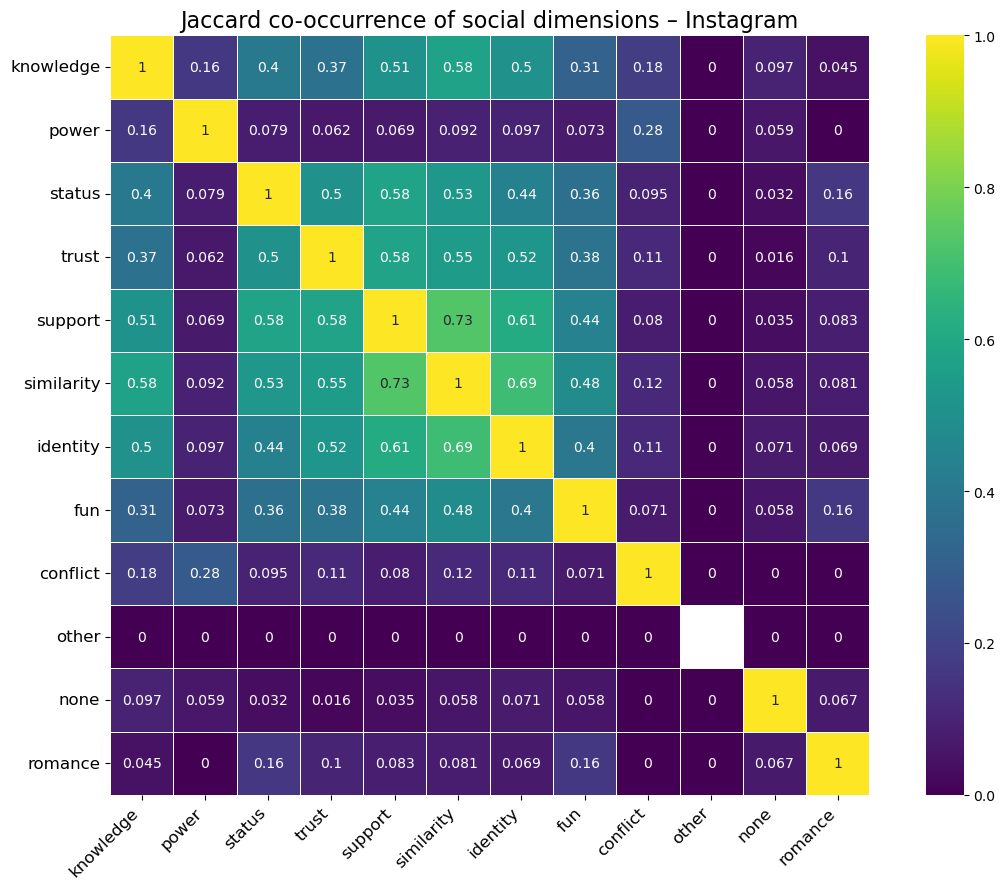

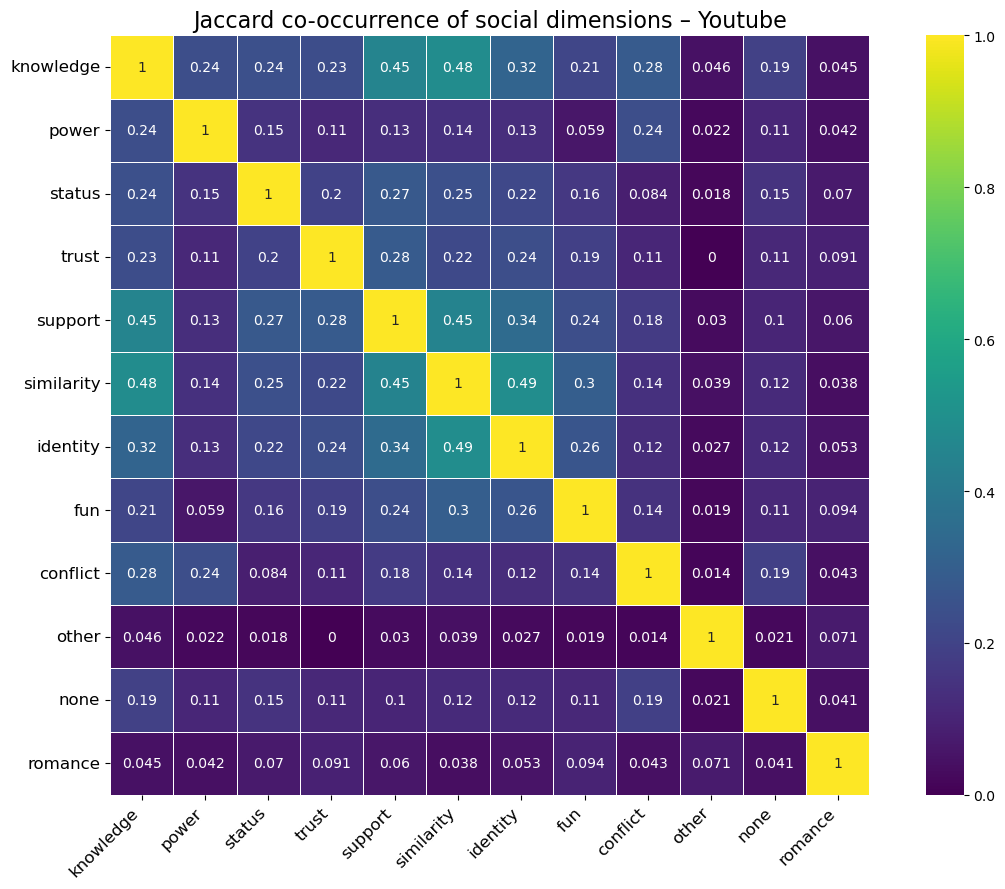

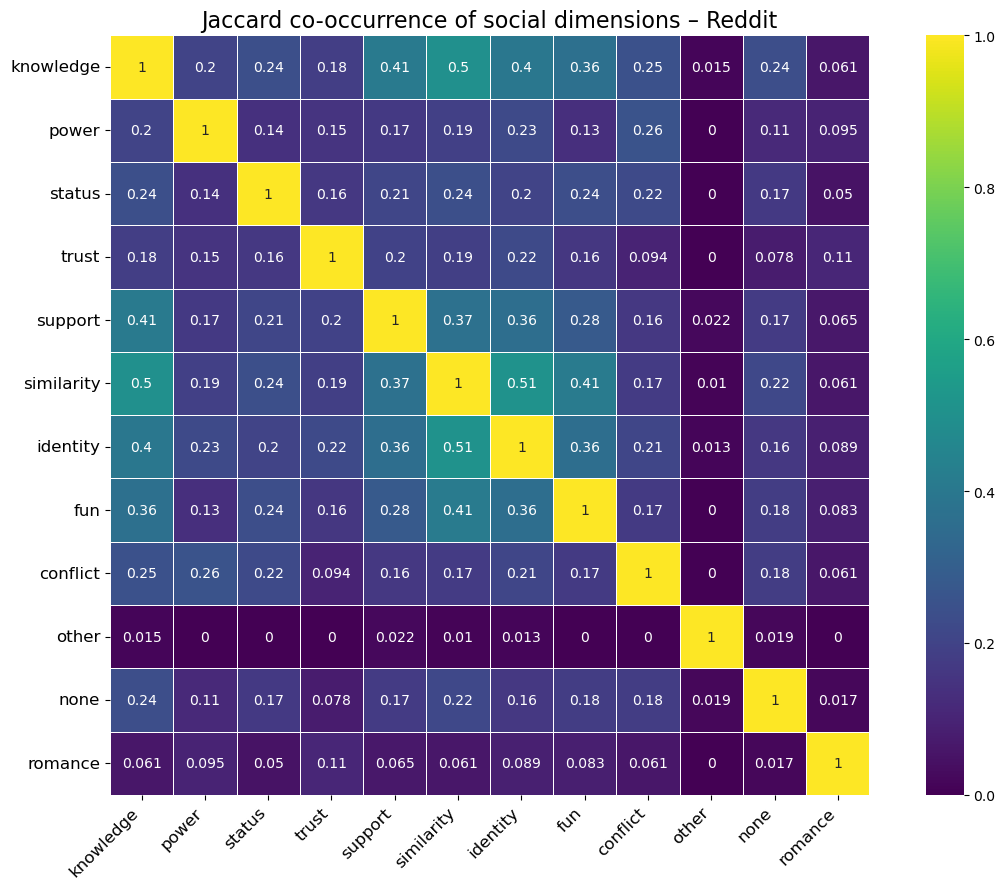

In [262]:
datasets = ['instagram', 'youtube', 'reddit']
for platform in datasets:
    df_platform = annotations_agg[annotations_agg['dataset'] == platform]
    
    cooccurrence_jaccard = pd.DataFrame(index=dims, columns=dims)
    for d1 in dims:
        for d2 in dims:
            cooccurrence_jaccard.loc[d1,d2] = (
                (df_platform[d1] & df_platform[d2]).sum() / (df_platform[d1] | df_platform[d2]).sum()
            )
    cooccurrence_jaccard = cooccurrence_jaccard.astype(float)
    
    plt.figure(figsize=(12,9))
    sns.heatmap(cooccurrence_jaccard, annot=True, cmap='viridis', linewidths=0.5, square=True)
    plt.title(f'Jaccard co-occurrence of social dimensions – {platform.capitalize()}', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
